In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Interpretive structural modeling (ISM)

The key principle of ISM is “Model Exchange Isomorphism (MEI)”. MEI essentially means that a matrix or structured model in one step holds a similar, although not identical, structure as a matrix or structured model in a second step within an ISM exercise. <br>
The core operational tool of ISM is to use Boolegan algebra and matrix theory to delineate a complex system into a multilayered and multi-blocked structural model, via reachability matrix (RM).

In [2]:
def get_boolean_matrix(matrix):
    matrix[matrix != 0] = 1
    return(matrix)

### Step 1-2: Initial Reachability Matrix (IRM) 
ISM demands rigor to expert opinions in designing datasets: experts have to be very conscious of and explicit about the bivariate relationships among the indicators within the dataset when constructing the Initial Reachability Matrix (IRM)

In [3]:
irm = np.array([[1,0,1,0,1,0,0,0,1,1,0,0],
                [0,1,0,1,0,0,1,0,0,0,0,0],
                [0,0,1,0,0,0,0,0,0,0,0,0],
                [0,0,0,1,0,0,0,0,0,0,0,0],
                [0,0,1,0,1,0,0,0,1,0,0,0],
                [0,0,0,0,0,1,0,0,0,0,0,0],
                [0,1,0,1,0,0,1,0,0,0,0,1],
                [0,0,0,0,0,0,0,1,0,1,0,0],
                [1,0,1,0,1,0,0,0,1,1,0,0],
                [0,0,1,0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,0,1,1,0],
                [0,0,0,1,1,0,0,0,0,0,0,1],
                ])

### Step 3: Structural Self-interaction Matrix (SSIM)
the IRM is transformed into a Structural Self-interaction Matrix (SSIM), denoted as matrix $A$ (below for a concrete example), according to the following rules of assigning values to aij: “$V$” and “$X$” are assigned the value of $1$ whereas “$A$” and “$O$” the value of $0$. Hence, within SSIM $A$, $1$ denotes the logic that that $S_i$ affects $S_j$ (within one knot) whereas $0$ denotes the logic that $S_i$ does not affect $S_j$ (within one knot). Because all relations between two elements are measured as a binary value, the SSIM matrix $A$ is a Boolean matrix (i.e., elements within it can only take the value of zero or one).

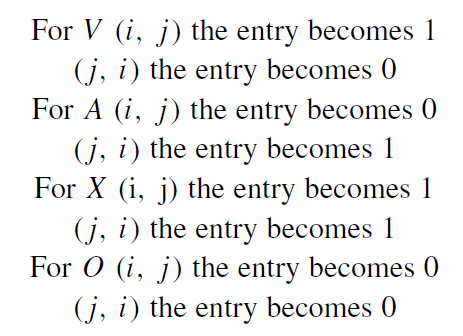

In [4]:
g = nx.from_numpy_array(irm, create_using = nx.DiGraph)
n = len(irm)
edgelist = [[f_node, t_node] for f_node,t_node,_ in nx.to_edgelist(g)]
ssim = []
for i in range(len(irm)):
    row = []
    for j in range(i, len(irm)):
        if [i, j] in edgelist:
            value = "X" if [j, i] in edgelist else "V"
        else:
            value = "A" if [j, i] in edgelist else "O"
        row.append(value)
    row = [""] * (n - len(row)) + row
    ssim.append(row)
pd.DataFrame(ssim) # Initial Reachaility Matrix

,0,1,2,3,4,5,6,7,8,9,10,11
0,X,O,V,O,V,O,O,O,X,V,O,O
1,,X,O,V,O,O,X,O,O,O,O,O
2,,,X,O,A,O,O,O,A,A,O,O
3,,,,X,O,O,A,O,O,O,O,A
4,,,,,X,O,O,O,X,O,O,A
5,,,,,,X,O,O,O,O,O,O
6,,,,,,,X,O,O,O,O,V
7,,,,,,,,X,O,V,O,O
8,,,,,,,,,X,V,O,O
9,,,,,,,,,,X,A,O


### Step 4: Final Reachability Matrix (M)
When $(A + I)^{k+1}$=$(A + I)^{k}$, then $(A + I)^{k}$is the FRM ($M$).

In [5]:
def find_FRM(matrix):
    matrix_pre = get_boolean_matrix(matrix+np.eye(len(matrix))) # k == 1, (A + I)^k
    k = 2
    matrix_aft = get_boolean_matrix(np.linalg.matrix_power(get_boolean_matrix(matrix+np.eye(len(matrix))), k)) # k == 2, (A + I)^k
    while not (matrix_pre == matrix_aft).all():
        k += 1
        matrix_pre, matrix_aft = matrix_aft, get_boolean_matrix(np.linalg.matrix_power(get_boolean_matrix(matrix+np.eye(len(matrix))), k)) # k, k + 1
    return matrix_pre

In [6]:
def warshall_matrix(matrix):
    n = len(matrix)
    for i in range(n):
        for j in range(n):
            if int(matrix[j][i]) == 1:
                for k in range(n):
                    matrix[j][k] = matrix[i][k] or matrix[j][k]
    return matrix

In [7]:
frm = warshall_matrix(irm) # same as find_FRM
# frm = find_FRM(irm)
# frm = get_boolean_matrix(irm+np.eye(len(irm)))
pd.DataFrame(frm, columns = [*range(1,13)], index = [*range(1,13)]).astype(int)

,1,2,3,4,5,6,7,8,9,10,11,12
1,1,0,1,0,1,0,0,0,1,1,0,0
2,1,1,1,1,1,0,1,0,1,1,0,1
3,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0
5,1,0,1,0,1,0,0,0,1,1,0,0
6,0,0,0,0,0,1,0,0,0,0,0,0
7,1,1,1,1,1,0,1,0,1,1,0,1
8,0,0,1,0,0,0,0,1,0,1,0,0
9,1,0,1,0,1,0,0,0,1,1,0,0
10,0,0,1,0,0,0,0,0,0,1,0,0


### Step 5: Streamed Final Reachability Matrix (SFRM)
Fifth, after obtaining the FRM (i.e., $M$), we then perform the operation of $M^*=m-m^2$ (where $m=M-I$) to eliminate redundant connections among the elements within $M$ to arrive at $M^*$ as the streamed final reachability matrix (SFRM).

In [8]:
matrix_m = frm - np.eye(len(frm))
sfrm = get_boolean_matrix(matrix_m - np.linalg.matrix_power(matrix_m, 2))
pd.DataFrame(sfrm, columns = [*range(1,13)], index = [*range(1,13)]).astype(int)
# tem = pd.DataFrame(sfrm, columns = [*range(1,13)], index = [*range(1,13)]).astype(int)
# dependence_power = pd.DataFrame(tem.sum(axis = 0), columns = ["dependence_power"]).T
# tem["driving_power"] = tem.sum(axis = 1)
# tem = pd.concat([tem, dependence_power], axis = 0)
# tem

,1,2,3,4,5,6,7,8,9,10,11,12
1,1,0,1,0,0,0,0,0,0,1,0,0
2,1,1,1,1,1,0,1,0,1,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,1,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0
7,1,1,1,1,1,0,1,0,1,1,0,0
8,0,0,0,0,0,0,0,0,0,1,0,0
9,0,0,1,0,0,0,0,0,1,1,0,0
10,0,0,1,0,0,0,0,0,0,0,0,0


### Step 6: Graph
Results contained within the SFRM are presented in the form of a directed graph to facilitate interpretation.

### Transitivity and Final Matrix
Initial Reachability Matrix + Streamed Final Reachability Matrix

In [9]:
tfm = pd.DataFrame(get_boolean_matrix(irm + sfrm), columns = [*range(1,13)], index = [*range(1,13)]).astype(int)
tfm

,1,2,3,4,5,6,7,8,9,10,11,12
1,1,0,1,0,1,0,0,0,1,1,0,0
2,1,1,1,1,1,0,1,0,1,1,0,1
3,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0
5,1,0,1,0,1,0,0,0,1,1,0,0
6,0,0,0,0,0,1,0,0,0,0,0,0
7,1,1,1,1,1,0,1,0,1,1,0,1
8,0,0,1,0,0,0,0,1,0,1,0,0
9,1,0,1,0,1,0,0,0,1,1,0,0
10,0,0,1,0,0,0,0,0,0,1,0,0


### Level Partitioning

In [10]:
antecedent = []
reachability = []
intersection = []
for i in range(len(tfm)):
    row = tfm.iloc[i, :].values
    row = np.where(row==1)[0] + 1
    column = tfm.iloc[:, i].values
    column = np.where(column==1)[0] + 1
    intersect = set(row).intersection(column)
    antecedent.append(row)
    reachability.append(column)
    intersection.append(intersect)

lp_df = pd.DataFrame({"name":[*range(1,len(tfm)+1)], "Reachability Set":reachability, "Antecedent Set":antecedent, "Intersection Set":intersection}, )
lp_df["Dependency Power"] = lp_df["Reachability Set"].apply(lambda x: len(x))
lp_df["Driving Power"] = lp_df["Antecedent Set"].apply(lambda x: len(x))
lp_df

,name,Reachability Set,Antecedent Set,Intersection Set,Dependency Power,Driving Power
0,1,"[1, 2, 5, 7, 9, 12]","[1, 3, 5, 9, 10]","{1, 5, 9}",6,5
1,2,"[2, 7]","[1, 2, 3, 4, 5, 7, 9, 10, 12]","{2, 7}",2,9
2,3,"[1, 2, 3, 5, 7, 8, 9, 10, 11, 12]",[3],{3},10,1
3,4,"[2, 4, 7, 12]",[4],{4},4,1
4,5,"[1, 2, 5, 7, 9, 12]","[1, 3, 5, 9, 10]","{1, 5, 9}",6,5
5,6,[6],[6],{6},1,1
6,7,"[2, 7]","[1, 2, 3, 4, 5, 7, 9, 10, 12]","{2, 7}",2,9
7,8,[8],"[3, 8, 10]",{8},1,3
8,9,"[1, 2, 5, 7, 9, 12]","[1, 3, 5, 9, 10]","{1, 5, 9}",6,5
9,10,"[1, 2, 5, 7, 8, 9, 10, 11, 12]","[3, 10]",{10},9,2


In [11]:
def renew_df(lp_df):
    lp_df["Intersection Set"] = lp_df.apply(lambda x: set(x["Reachability Set"]).intersection(set(x["Antecedent Set"])), axis = 1)
    lp_df["Dependency Power"] = lp_df["Reachability Set"].apply(lambda x: len(x))
    lp_df["Driving Power"] = lp_df["Antecedent Set"].apply(lambda x: len(x))
    return lp_df

In [12]:
def del_df(lp_df, node_lst):
    tem = lp_df[["name","Reachability Set","Antecedent Set"]]
    tem = tem[tem["name"].apply(lambda x: True if x not in node_lst else False)]
    tem.loc[:,"Reachability Set"] = tem["Reachability Set"].apply(lambda x: [i for i in x if i not in node_lst])
    tem.loc[:,"Antecedent Set"] = tem["Antecedent Set"].apply(lambda x: [i for i in x if i not in node_lst])
    tem = renew_df(tem)
    return tem

#### Level Partitioning Iterations 1

In [13]:
lvl = 1
dict_lvl = {}
closed = []
tem = lp_df[lp_df["Intersection Set"].apply(lambda x: True if len(x) == 1 else False)].reset_index(drop = True)
nodes = tem.loc[tem["Dependency Power"] == tem["Dependency Power"].max(), "name"].values
for node in nodes:
    dict_lvl[node] = lvl
lp_df = del_df(lp_df, nodes)
lp_df

,name,Reachability Set,Antecedent Set,Intersection Set,Dependency Power,Driving Power
0,1,"[1, 2, 5, 7, 9, 12]","[1, 5, 9, 10]","{1, 5, 9}",6,4
1,2,"[2, 7]","[1, 2, 4, 5, 7, 9, 10, 12]","{2, 7}",2,8
3,4,"[2, 4, 7, 12]",[4],{4},4,1
4,5,"[1, 2, 5, 7, 9, 12]","[1, 5, 9, 10]","{1, 5, 9}",6,4
5,6,[6],[6],{6},1,1
6,7,"[2, 7]","[1, 2, 4, 5, 7, 9, 10, 12]","{2, 7}",2,8
7,8,[8],"[8, 10]",{8},1,2
8,9,"[1, 2, 5, 7, 9, 12]","[1, 5, 9, 10]","{1, 5, 9}",6,4
9,10,"[1, 2, 5, 7, 8, 9, 10, 11, 12]",[10],{10},9,1
10,11,[11],"[10, 11]",{11},1,2


#### Level Partitioning Iterations 2

In [14]:
lvl = 2
tem = lp_df[lp_df["Intersection Set"].apply(lambda x: True if len(x) == 1 else False)].reset_index(drop = True)
nodes = tem.loc[tem["Dependency Power"] == tem["Dependency Power"].max(), "name"].values
for node in nodes:
    dict_lvl[node] = lvl
lp_df = del_df(lp_df, nodes)
lp_df

,name,Reachability Set,Antecedent Set,Intersection Set,Dependency Power,Driving Power
0,1,"[1, 2, 5, 7, 9, 12]","[1, 5, 9]","{1, 5, 9}",6,3
1,2,"[2, 7]","[1, 2, 4, 5, 7, 9, 12]","{2, 7}",2,7
3,4,"[2, 4, 7, 12]",[4],{4},4,1
4,5,"[1, 2, 5, 7, 9, 12]","[1, 5, 9]","{1, 5, 9}",6,3
5,6,[6],[6],{6},1,1
6,7,"[2, 7]","[1, 2, 4, 5, 7, 9, 12]","{2, 7}",2,7
7,8,[8],[8],{8},1,1
8,9,"[1, 2, 5, 7, 9, 12]","[1, 5, 9]","{1, 5, 9}",6,3
10,11,[11],[11],{11},1,1
11,12,"[2, 7, 12]","[1, 4, 5, 9, 12]",{12},3,5


#### Level Partitioning Iterations 3

In [15]:
lvl = 3
nodes1 = lp_df.loc[lp_df["Dependency Power"] == lp_df["Dependency Power"].max(), "name"].values
closed.append(nodes1)
tem = lp_df[lp_df["Intersection Set"].apply(lambda x: True if len(x) == 1 else False)].reset_index(drop = True)
nodes2 = tem.loc[tem["Dependency Power"] == tem["Dependency Power"].max(), "name"].values
nodes = np.append(nodes1, nodes2)
nodes = np.append(nodes, [8, 11])
for node in nodes:
    dict_lvl[node] = lvl
lp_df = del_df(lp_df, nodes)
lp_df

,name,Reachability Set,Antecedent Set,Intersection Set,Dependency Power,Driving Power
1,2,"[2, 7]","[2, 7, 12]","{2, 7}",2,3
5,6,[6],[6],{6},1,1
6,7,"[2, 7]","[2, 7, 12]","{2, 7}",2,3
11,12,"[2, 7, 12]",[12],{12},3,1


#### Level Partitioning Iterations 4

In [16]:
lvl = 4
tem = lp_df[lp_df["Intersection Set"].apply(lambda x: True if len(x) == 1 else False)].reset_index(drop = True)
nodes = tem.loc[tem["Dependency Power"] == tem["Dependency Power"].max(), "name"].values
for node in nodes:
    dict_lvl[node] = lvl
lp_df = del_df(lp_df, nodes)
lp_df

,name,Reachability Set,Antecedent Set,Intersection Set,Dependency Power,Driving Power
1,2,"[2, 7]","[2, 7]","{2, 7}",2,2
5,6,[6],[6],{6},1,1
6,7,"[2, 7]","[2, 7]","{2, 7}",2,2


#### Level Partitioning Iterations 5

In [17]:
lvl = 5
nodes1 = lp_df.loc[lp_df["Dependency Power"] == lp_df["Dependency Power"].max(), "name"].values
closed.append(nodes1)
tem = lp_df[lp_df["Intersection Set"].apply(lambda x: True if len(x) == 1 else False)].reset_index(drop = True)
nodes2 = tem.loc[tem["Dependency Power"] == tem["Dependency Power"].max(), "name"].values
nodes = np.append(nodes1, nodes2)
for node in nodes:
    dict_lvl[node] = lvl
dict_lvl

{3: 1, 10: 2, 1: 3, 5: 3, 9: 3, 4: 3, 8: 3, 11: 3, 12: 4, 2: 5, 7: 5, 6: 5}

In [18]:
def get_edgelist(matrix):
    from_n, to_n = np.where(matrix == 1)
    return [*zip(from_n, to_n)]

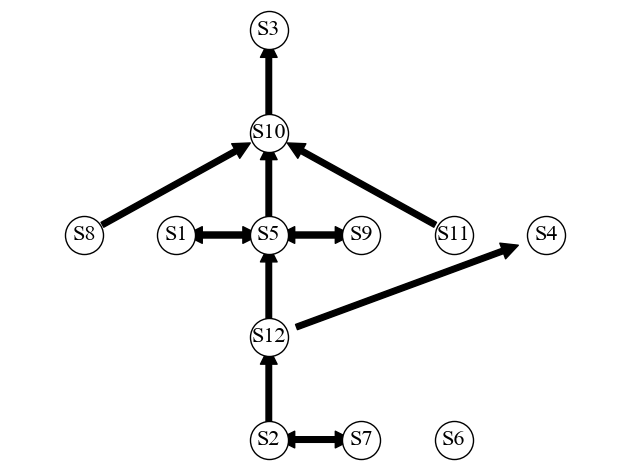

In [19]:
dict_node = {3: [3, -1],
             10: [3, -2],
             1: [2, -3],
             5: [3, -3],
             9: [4, -3],
             4: [6, -3],
             8: [1, -3],
             11: [5, -3],
             12: [3, -4],
             2: [3, -5],
             7: [4, -5],
             6: [5, -5]}
edgelist = list(set(get_edgelist(tfm)))
for cl in closed:
    if len(cl)%2 == 1:
        keep = cl[int((len(cl)+1)/2)-1]
    else:
        keep = cl[int((len(cl))/2)-1]
    res = [i for i in cl if i != keep]

    [edgelist.remove(edge) for edge in edgelist if (len(set(edge) & set([i-1 for i in res])) > 0) and (keep-1 not in edge)]
    
name = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11", "S12"]
dict_name = {i:j for i,j in zip(range(1,len(name)+1), name)}

fig, ax = plt.subplots() 
for i in dict_node:
    label = i
    x,y = dict_node[label]
    ax.scatter(x, y, s = 750, linewidth = 1, facecolor = "white", edgecolor = "black", zorder = 5)
    ax.text(x, y, dict_name[label], ha = "center", va = "center", fontfamily = "Times New Roman", fontsize = 16, zorder = 10)

for edge in edgelist:
    pfrom = dict_node[edge[0]+1]
    pto = dict_node[edge[1]+1]
    dx = pto[0] - pfrom[0]
    dy = pto[1] - pfrom[1]
    if - pfrom[1] + pto[1] <= 1:
        ax.annotate("", xy = pto, xytext = pfrom, arrowprops=dict(facecolor='black', shrink=0.1),
                horizontalalignment='left',
                verticalalignment='bottom')

xmin,xmax = ax.get_xlim()
gap = xmax - xmin
ax.set_xlim([xmin - gap/10, xmax + gap/10])

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.spines['top'].set_color("none")
ax.spines['bottom'].set_color("none")
ax.spines['left'].set_color("none")
ax.spines['right'].set_color("none")
ax.tick_params(axis='both', which = "both", length = 0)

fig.tight_layout()
plt.show()